In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
import re
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
from tensorflow.keras import layers
from keras import optimizers
from keras.layers import Input, Flatten, Activation, Dense, BatchNormalization, Dropout, Conv2D, MaxPooling2D
from keras.models import Model, load_model
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

In [2]:
height, width, depth = 96, 96, 3
save_path = 'python/first_model.model'

In [3]:
def load_dataset(path, height, width, least_num):
    image_list, label_list = [], []
    for root, dirs, files in os.walk(path):
        temp_images, temp_labels = [], []
        for file in files:
            try:
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)
                image = cv2.resize(image, (height, width))
                temp_images.append(image)
                temp_labels.append(root.split('\\')[1])
            except:
                continue
        if len(temp_images)>= least_num:
            image_list.extend(temp_images)
            label_list.extend(temp_labels)
            
    num_classes = len(np.unique(label_list))
    # num_classes = 1
    
    return image_list, label_list, num_classes

In [4]:
def vgg19_teranfer_learning(num_classes):
    model = keras.applications.vgg19
    vg19MODEL = model.VGG19(weights='imagenet', include_top=False, input_shape=(height, width, depth))

    X = keras.layers.Dropout(0.2)(vg19MODEL.output)
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(256, activation='relu', bias_regularizer=tf.keras.regularizers.L2(0.001), kernel_regularizer=tf.keras.regularizers.L2(0.001), activity_regularizer = tf.keras.regularizers.L2(0.001))(X)
    X = keras.layers.Dropout(0.2)(X)
    X = keras.layers.Dense(128, activation='relu',  bias_regularizer=tf.keras.regularizers.L2(0.001), kernel_regularizer=tf.keras.regularizers.L2(0.001), activity_regularizer = tf.keras.regularizers.L2(0.001))(X)
    X = keras.layers.Dropout(0.2)(X)
    X = keras.layers.Dense(64, activation='relu',  bias_regularizer=tf.keras.regularizers.L2(0.001), kernel_regularizer=tf.keras.regularizers.L2(0.001), activity_regularizer = tf.keras.regularizers.L2(0.001))(X)
    X = keras.layers.Dropout(0.2)(X)
    X = keras.layers.Dense(32, activation='relu',  bias_regularizer=tf.keras.regularizers.L2(0.001), kernel_regularizer=tf.keras.regularizers.L2(0.001), activity_regularizer = tf.keras.regularizers.L2(0.001))(X)
    X = keras.layers.Dropout(0.2)(X)
    X = keras.layers.Dense(16, activation='relu',  bias_regularizer=tf.keras.regularizers.L2(0.001), kernel_regularizer=tf.keras.regularizers.L2(0.001), activity_regularizer = tf.keras.regularizers.L2(0.001))(X)
    X = keras.layers.Dropout(0.2)(X)
    predictions = keras.layers.Dense(num_classes, activation='softmax', bias_regularizer=tf.keras.regularizers.L2(0.001), kernel_regularizer=tf.keras.regularizers.L2(0.001), activity_regularizer = tf.keras.regularizers.L2(0.001))(X)

    model = Model(inputs=vg19MODEL.input, outputs=predictions)
    
    for layer in model.layers[:20]:
        layer.trainable = False
    for layer in model.layers[20:]:
        layer.trainable = True
        
    return model

In [5]:
def train_model(model, epochs, save_path, train_X, train_y, test_X, test_y, data_augmentation = False):
    batch_size = 32
    early_stopping = EarlyStopping(patience=30, verbose=1)
    model_checkpoint = ModelCheckpoint(save_path, save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)
    callbacks = [early_stopping, model_checkpoint, reduce_lr]
    
    if data_augmentation:
        datagen = ImageDataGenerator(
            rescale=1/255.,
            featurewise_center=False, # Set input mean to 0 over the dataset, feature-wise.
            samplewise_center=False, # Set each sample mean to 0.
            featurewise_std_normalization=False, # Divide inputs by std of the dataset, feature-wise.
            samplewise_std_normalization=False, # Divide each input by its std.
            zca_whitening=False, # Apply ZCA whitening.
            rotation_range=15, # Degree range for random rotations.
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            vertical_flip=False)

    else:
        datagen = ImageDataGenerator(
            rescale=1/255)
    
    history = model.fit_generator(datagen.flow(train_X, train_y, batch_size=batch_size), 
                                  steps_per_epoch=len(train_X) / batch_size,
                                  validation_data=datagen.flow(test_X, test_y, batch_size=batch_size),
                                  validation_steps=len(test_X) / batch_size,
                                  epochs=epochs,
                                  callbacks=callbacks)
    
    return model, history

In [6]:
image_list, label_list, num_classes = load_dataset('/Users/User/Downloads/archive/pizza_not_pizza', height, width, 300)

In [7]:
le = LabelEncoder()
label_list = le.fit_transform(label_list)

np.save('classes.npy', le.classes_)

In [8]:
train_X, test_X, train_y, test_y = train_test_split(np.array(image_list), label_list, test_size = 0.2, stratify = label_list)

In [9]:
train_y = np_utils.to_categorical(train_y)
test_y = np_utils.to_categorical(test_y)

In [10]:
model = vgg19_teranfer_learning(num_classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

In [11]:
model.layers[20:]

In [12]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics =['accuracy'])  

In [13]:
model, history = train_model(model, 200, save_path, train_X, train_y, test_X, test_y, data_augmentation = False)

Epoch 1/200


C:\Users\User\AppData\Local\Temp\ipykernel_2172\596077518.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(train_X, train_y, batch_size=batch_size),


50/49 [==============================] - ETA: 0s - loss: 1.2231 - accuracy: 0.6819
Epoch 1: val_loss improved from inf to 0.96322, saving model to python\first_model.model


INFO:tensorflow:Assets written to: python\first_model.model\assets


INFO:tensorflow:Assets written to: python\first_model.model\assets


49/49 [==============================] - 55s 1s/step - loss: 1.2231 - accuracy: 0.6819 - val_loss: 0.9632 - val_accuracy: 0.8426 - lr: 0.0010
Epoch 2/200
50/49 [==============================] - ETA: 0s - loss: 0.8925 - accuracy: 0.8193
Epoch 2: val_loss improved from 0.96322 to 0.79649, saving model to python\first_model.model


INFO:tensorflow:Assets written to: python\first_model.model\assets


INFO:tensorflow:Assets written to: python\first_model.model\assets


49/49 [==============================] - 53s 1s/step - loss: 0.8925 - accuracy: 0.8193 - val_loss: 0.7965 - val_accuracy: 0.8655 - lr: 0.0010
Epoch 3/200
50/49 [==============================] - ETA: 0s - loss: 0.7097 - accuracy: 0.8601
Epoch 3: val_loss improved from 0.79649 to 0.57766, saving model to python\first_model.model


INFO:tensorflow:Assets written to: python\first_model.model\assets


INFO:tensorflow:Assets written to: python\first_model.model\assets


49/49 [==============================] - 54s 1s/step - loss: 0.7097 - accuracy: 0.8601 - val_loss: 0.5777 - val_accuracy: 0.8426 - lr: 0.0010
Epoch 4/200
50/49 [==============================] - ETA: 0s - loss: 0.5459 - accuracy: 0.8804
Epoch 4: val_loss improved from 0.57766 to 0.49676, saving model to python\first_model.model


INFO:tensorflow:Assets written to: python\first_model.model\assets


INFO:tensorflow:Assets written to: python\first_model.model\assets


49/49 [==============================] - 54s 1s/step - loss: 0.5459 - accuracy: 0.8804 - val_loss: 0.4968 - val_accuracy: 0.8706 - lr: 0.0010
Epoch 5/200
50/49 [==============================] - ETA: 0s - loss: 0.4843 - accuracy: 0.9001
Epoch 5: val_loss improved from 0.49676 to 0.48100, saving model to python\first_model.model


INFO:tensorflow:Assets written to: python\first_model.model\assets


INFO:tensorflow:Assets written to: python\first_model.model\assets


49/49 [==============================] - 54s 1s/step - loss: 0.4843 - accuracy: 0.9001 - val_loss: 0.4810 - val_accuracy: 0.8655 - lr: 0.0010
Epoch 6/200
50/49 [==============================] - ETA: 0s - loss: 0.3971 - accuracy: 0.9326
Epoch 6: val_loss improved from 0.48100 to 0.47771, saving model to python\first_model.model


INFO:tensorflow:Assets written to: python\first_model.model\assets


INFO:tensorflow:Assets written to: python\first_model.model\assets


49/49 [==============================] - 54s 1s/step - loss: 0.3971 - accuracy: 0.9326 - val_loss: 0.4777 - val_accuracy: 0.8680 - lr: 0.0010
Epoch 7/200
50/49 [==============================] - ETA: 0s - loss: 0.3479 - accuracy: 0.9396
Epoch 7: val_loss improved from 0.47771 to 0.44859, saving model to python\first_model.model


INFO:tensorflow:Assets written to: python\first_model.model\assets


INFO:tensorflow:Assets written to: python\first_model.model\assets


49/49 [==============================] - 55s 1s/step - loss: 0.3479 - accuracy: 0.9396 - val_loss: 0.4486 - val_accuracy: 0.8604 - lr: 0.0010
Epoch 8/200
50/49 [==============================] - ETA: 0s - loss: 0.3052 - accuracy: 0.9491
Epoch 8: val_loss improved from 0.44859 to 0.40880, saving model to python\first_model.model


INFO:tensorflow:Assets written to: python\first_model.model\assets


INFO:tensorflow:Assets written to: python\first_model.model\assets


49/49 [==============================] - 51s 1s/step - loss: 0.3052 - accuracy: 0.9491 - val_loss: 0.4088 - val_accuracy: 0.8883 - lr: 0.0010
Epoch 9/200
50/49 [==============================] - ETA: 0s - loss: 0.3060 - accuracy: 0.9453
Epoch 9: val_loss did not improve from 0.40880
49/49 [==============================] - 50s 1s/step - loss: 0.3060 - accuracy: 0.9453 - val_loss: 0.4218 - val_accuracy: 0.8629 - lr: 0.0010
Epoch 10/200
50/49 [==============================] - ETA: 0s - loss: 0.2490 - accuracy: 0.9618
Epoch 10: val_loss did not improve from 0.40880
49/49 [==============================] - 51s 1s/step - loss: 0.2490 - accuracy: 0.9618 - val_loss: 0.4415 - val_accuracy: 0.8655 - lr: 0.0010
Epoch 11/200
50/49 [==============================] - ETA: 0s - loss: 0.2239 - accuracy: 0.9726
Epoch 11: val_loss improved from 0.40880 to 0.38759, saving model to python\first_model.model


INFO:tensorflow:Assets written to: python\first_model.model\assets


INFO:tensorflow:Assets written to: python\first_model.model\assets


49/49 [==============================] - 56s 1s/step - loss: 0.2239 - accuracy: 0.9726 - val_loss: 0.3876 - val_accuracy: 0.8883 - lr: 0.0010
Epoch 12/200
50/49 [==============================] - ETA: 0s - loss: 0.2166 - accuracy: 0.9714
Epoch 12: val_loss did not improve from 0.38759
49/49 [==============================] - 51s 1s/step - loss: 0.2166 - accuracy: 0.9714 - val_loss: 0.3986 - val_accuracy: 0.8832 - lr: 0.0010
Epoch 13/200
50/49 [==============================] - ETA: 0s - loss: 0.2100 - accuracy: 0.9752
Epoch 13: val_loss did not improve from 0.38759
49/49 [==============================] - 52s 1s/step - loss: 0.2100 - accuracy: 0.9752 - val_loss: 0.4224 - val_accuracy: 0.8883 - lr: 0.0010
Epoch 14/200
50/49 [==============================] - ETA: 0s - loss: 0.1876 - accuracy: 0.9816
Epoch 14: val_loss did not improve from 0.38759
49/49 [==============================] - 52s 1s/step - loss: 0.1876 - accuracy: 0.9816 - val_loss: 0.4298 - val_accuracy: 0.8883 - lr: 0.0010


INFO:tensorflow:Assets written to: python\first_model.model\assets


INFO:tensorflow:Assets written to: python\first_model.model\assets


49/49 [==============================] - 56s 1s/step - loss: 0.1536 - accuracy: 0.9924 - val_loss: 0.3401 - val_accuracy: 0.9162 - lr: 5.0000e-04
Epoch 18/200
50/49 [==============================] - ETA: 0s - loss: 0.1319 - accuracy: 0.9955
Epoch 18: val_loss did not improve from 0.34014
49/49 [==============================] - 52s 1s/step - loss: 0.1319 - accuracy: 0.9955 - val_loss: 0.3827 - val_accuracy: 0.9061 - lr: 5.0000e-04
Epoch 19/200
50/49 [==============================] - ETA: 0s - loss: 0.1219 - accuracy: 0.9968
Epoch 19: val_loss did not improve from 0.34014
49/49 [==============================] - 51s 1s/step - loss: 0.1219 - accuracy: 0.9968 - val_loss: 0.3677 - val_accuracy: 0.9086 - lr: 5.0000e-04
Epoch 20/200
50/49 [==============================] - ETA: 0s - loss: 0.1235 - accuracy: 0.9943
Epoch 20: val_loss did not improve from 0.34014
49/49 [==============================] - 51s 1s/step - loss: 0.1235 - accuracy: 0.9943 - val_loss: 0.3498 - val_accuracy: 0.9213 -

INFO:tensorflow:Assets written to: python\first_model.model\assets


INFO:tensorflow:Assets written to: python\first_model.model\assets


49/49 [==============================] - 54s 1s/step - loss: 0.1120 - accuracy: 0.9975 - val_loss: 0.3341 - val_accuracy: 0.9289 - lr: 5.0000e-04
Epoch 22/200
50/49 [==============================] - ETA: 0s - loss: 0.1065 - accuracy: 0.9981
Epoch 22: val_loss did not improve from 0.33409
49/49 [==============================] - 53s 1s/step - loss: 0.1065 - accuracy: 0.9981 - val_loss: 0.3542 - val_accuracy: 0.9315 - lr: 5.0000e-04
Epoch 23/200
50/49 [==============================] - ETA: 0s - loss: 0.1027 - accuracy: 0.9994
Epoch 23: val_loss did not improve from 0.33409
49/49 [==============================] - 52s 1s/step - loss: 0.1027 - accuracy: 0.9994 - val_loss: 0.3459 - val_accuracy: 0.9264 - lr: 5.0000e-04
Epoch 24/200
50/49 [==============================] - ETA: 0s - loss: 0.1058 - accuracy: 0.9975
Epoch 24: val_loss did not improve from 0.33409
49/49 [==============================] - 54s 1s/step - loss: 0.1058 - accuracy: 0.9975 - val_loss: 0.3786 - val_accuracy: 0.9086 -

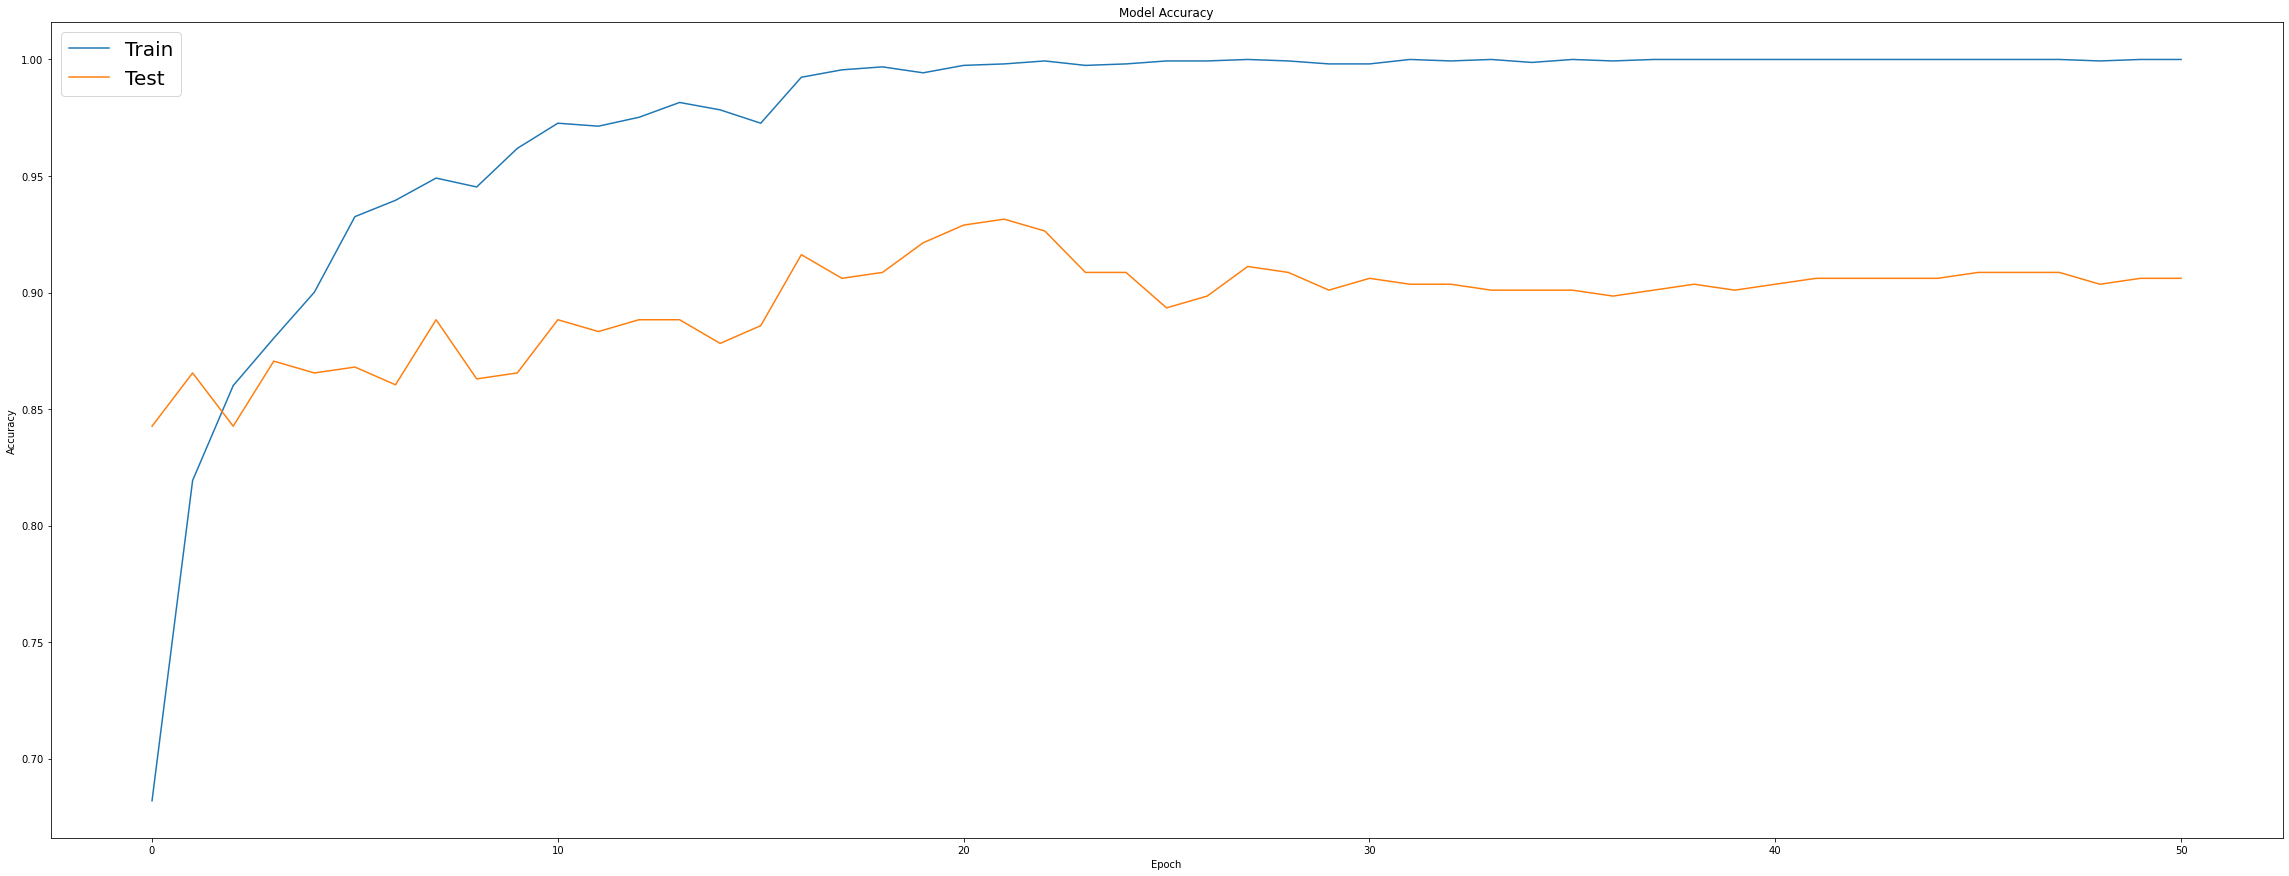

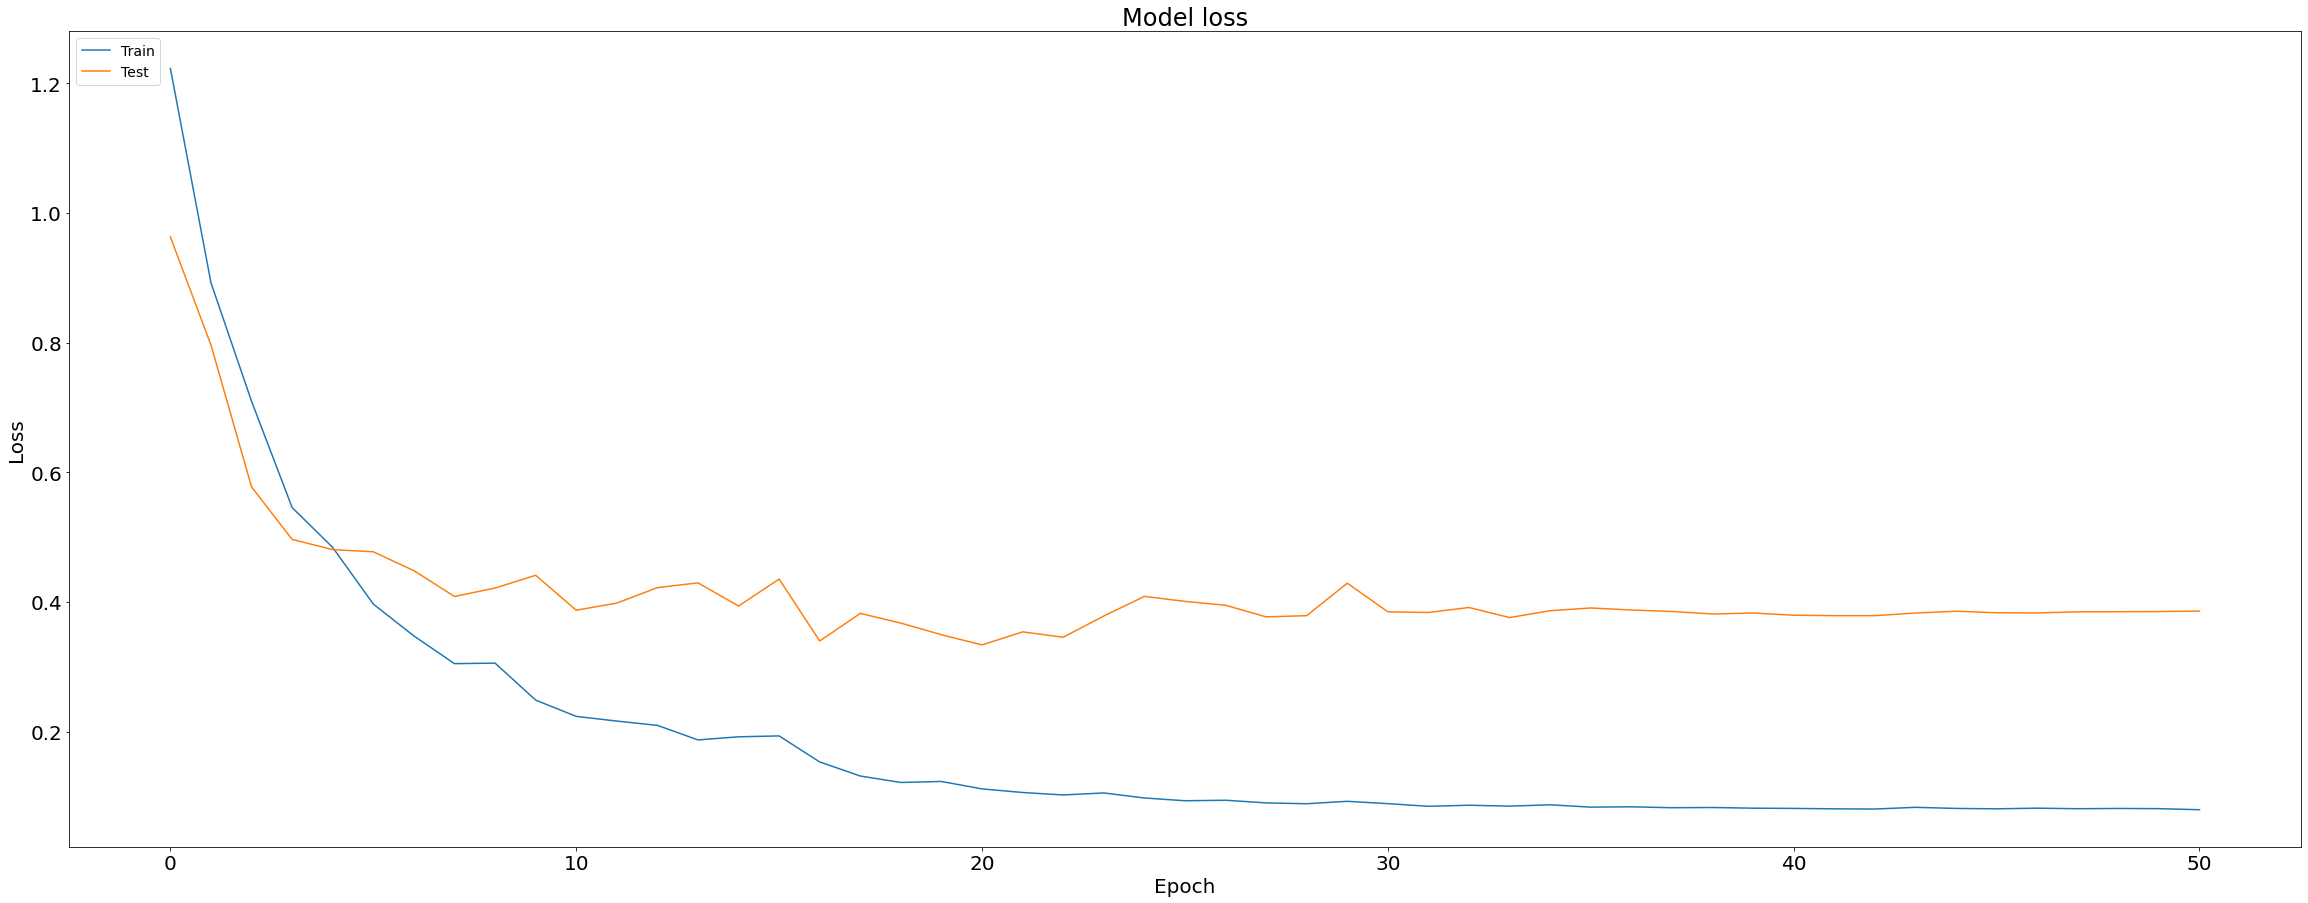

In [14]:
plt.figure(figsize = (40,15))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.rcParams['font.size'] = '20'
plt.legend(['Train', 'Test'], loc='upper left', fontsize = 20)
plt.show()

plt.figure(figsize = (40,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.rcParams['font.size'] = '20'
plt.legend(['Train', 'Test'], loc='upper left', fontsize = 14)
plt.show()

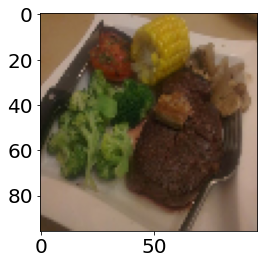

1/1 [==============================] - 0s 62ms/step
[[9.9996936e-01 3.0577776e-05]]
0


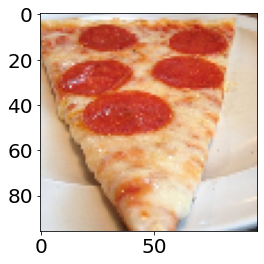

1/1 [==============================] - 0s 59ms/step
[[9.6171552e-06 9.9999034e-01]]
1


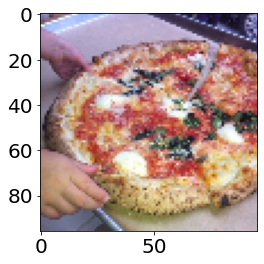

1/1 [==============================] - 0s 70ms/step
[[3.4232038e-05 9.9996579e-01]]
1


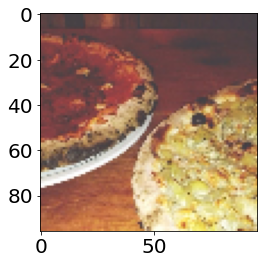

1/1 [==============================] - 0s 67ms/step
[[3.657991e-05 9.999634e-01]]
1


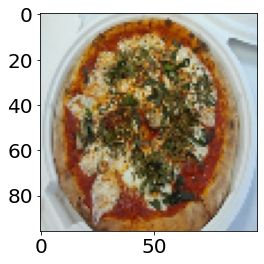

1/1 [==============================] - 0s 54ms/step
[[4.4016462e-05 9.9995601e-01]]
1


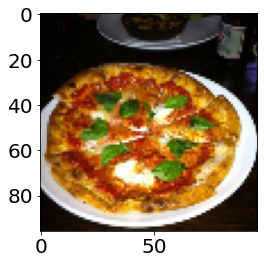

1/1 [==============================] - 0s 46ms/step
[[1.7214557e-05 9.9998283e-01]]
1


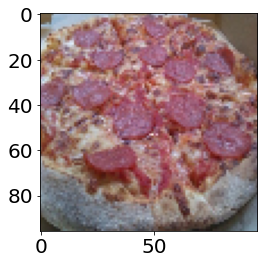

1/1 [==============================] - 0s 70ms/step
[[4.0704555e-05 9.9995935e-01]]
1


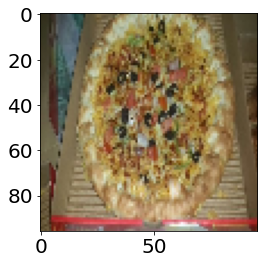

1/1 [==============================] - 0s 47ms/step
[[3.0908483e-05 9.9996912e-01]]
1


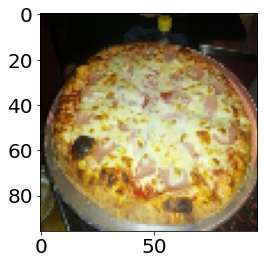

1/1 [==============================] - 0s 60ms/step
[[8.227727e-06 9.999918e-01]]
1


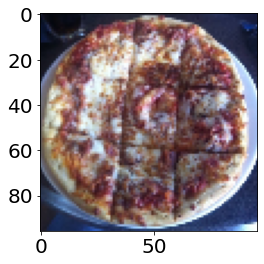

1/1 [==============================] - 0s 54ms/step
[[4.7920235e-05 9.9995208e-01]]
1


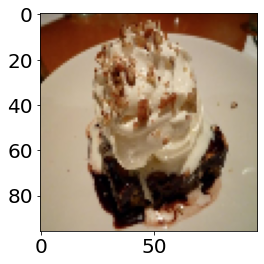

1/1 [==============================] - 0s 62ms/step
[[9.999676e-01 3.244661e-05]]
0


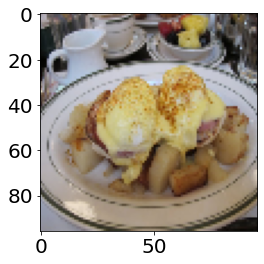

1/1 [==============================] - 0s 79ms/step
[[9.999306e-01 6.936853e-05]]
0


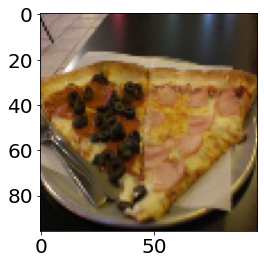

1/1 [==============================] - 0s 52ms/step
[[3.2002405e-05 9.9996805e-01]]
1


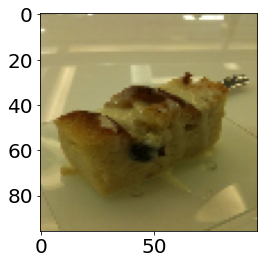

1/1 [==============================] - 0s 77ms/step
[[9.999937e-01 6.258668e-06]]
0


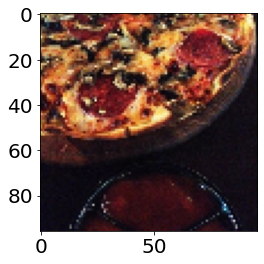

1/1 [==============================] - 0s 55ms/step
[[3.704456e-05 9.999629e-01]]
1


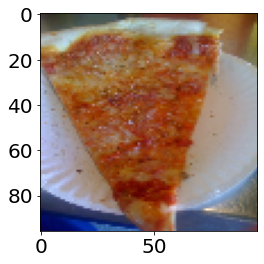

1/1 [==============================] - 0s 55ms/step
[[2.300076e-05 9.999770e-01]]
1


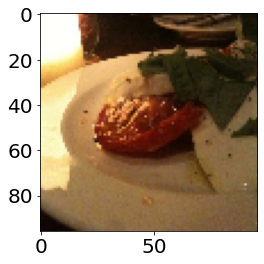

1/1 [==============================] - 0s 77ms/step
[[9.9999022e-01 9.7463435e-06]]
0


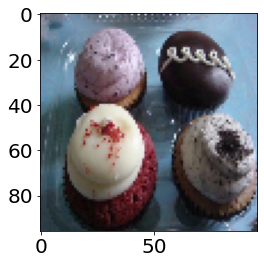

1/1 [==============================] - 0s 59ms/step
[[9.9994230e-01 5.7716785e-05]]
0


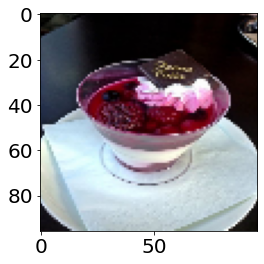

1/1 [==============================] - 0s 72ms/step
[[9.999995e-01 4.911705e-07]]
0


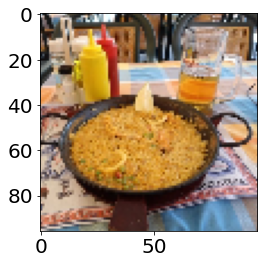

1/1 [==============================] - 0s 43ms/step
[[9.999907e-01 9.242348e-06]]
0


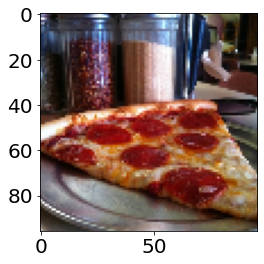

1/1 [==============================] - 0s 79ms/step
[[1.4529435e-05 9.9998546e-01]]
1


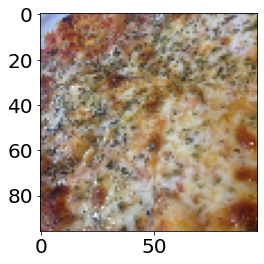

1/1 [==============================] - 0s 73ms/step
[[4.107033e-05 9.999589e-01]]
1


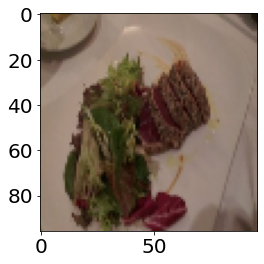

1/1 [==============================] - 0s 71ms/step
[[9.9998748e-01 1.2556516e-05]]
0


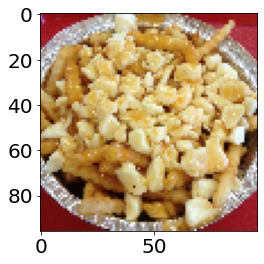

1/1 [==============================] - 0s 54ms/step
[[9.9981672e-01 1.8329525e-04]]
0


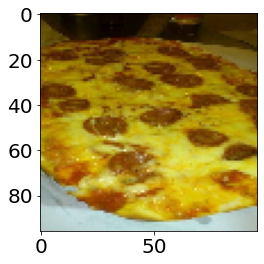

1/1 [==============================] - 0s 53ms/step
[[2.9683302e-05 9.9997032e-01]]
1


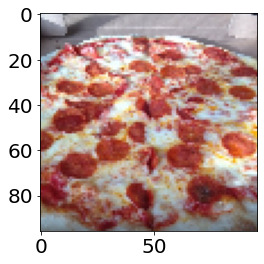

1/1 [==============================] - 0s 64ms/step
[[1.8714123e-05 9.9998128e-01]]
1


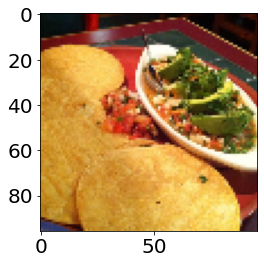

1/1 [==============================] - 0s 48ms/step
[[9.9959511e-01 4.0491976e-04]]
0


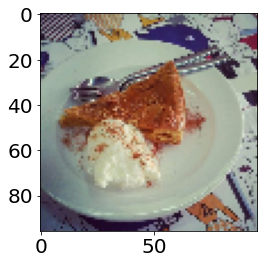

1/1 [==============================] - 0s 45ms/step
[[0.9951315  0.00486853]]
0


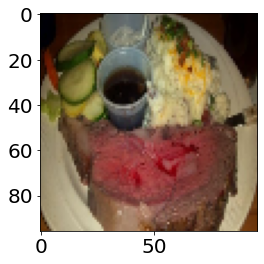

1/1 [==============================] - 0s 46ms/step
[[9.999101e-01 8.982285e-05]]
0


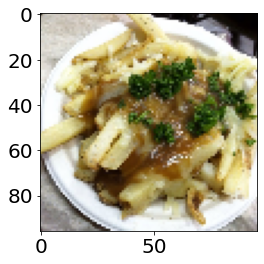

1/1 [==============================] - 0s 74ms/step
[[9.99986768e-01 1.32367395e-05]]
0


In [37]:
# plt.figure(figsize = (96,96))
# image = cv2.imread(image)

for _ in range(30):
    
    i = random.randint(0, len(image_list))

    img_rgb = cv2.cvtColor(image_list[i], cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()

    pred_train = model.predict(np.expand_dims(image_list[i] / 255., axis=0))
    print(pred_train)
    print(label_list[i])

In [75]:
batch_size = 32
datagen = ImageDataGenerator(rescale=1/255)
validation_data = datagen.flow(test_X, test_y, batch_size=batch_size, shuffle=False)
model.evaluate(validation_data, batch_size = batch_size, steps= len(test_X) / batch_size)

12/12 [==============================] - 10s 780ms/step - loss: 0.3863 - accuracy: 0.9061


[0.38630977272987366, 0.9060913920402527]

In [76]:
Y_pred = model.predict(validation_data,  workers=1)
y_pred = np.argmax(Y_pred ,  axis = 1)

13/13 [==============================] - 9s 724ms/step


In [77]:
res = tf.math.confusion_matrix(y_pred, np.argmax(test_y, axis = 1)).numpy()
confusion_matrix = pd.DataFrame(res,
                     index = le.classes_, 
                     columns = le.classes_)

In [78]:
res

array([[180,  20],
       [ 17, 177]])

In [79]:
confusion_matrix

,not_pizza,pizza
not_pizza,180,20
pizza,17,177


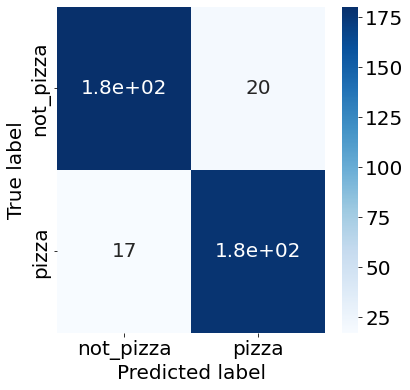

In [80]:
figure = plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix, annot=True, cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()